In [82]:
pip install XGBoost

     ---------------------------------------- 124.9/124.9 MB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, mean_absolute_error, f1_score
import pickle

In [40]:
df = pd.read_csv("full_dataset.csv", index_col=0)
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,31570,belo horizonte,SP
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,232.0,1.0,420.0,24.0,19.0,21.0,auto,14840,guariba,SP


In [41]:
df['seller_id']

0         3504c0cb71d7fa48d967e0e4c94d59d9
1         3504c0cb71d7fa48d967e0e4c94d59d9
2         3504c0cb71d7fa48d967e0e4c94d59d9
3         289cdb325fb7e7f891c38608bf9e0962
4         4869f7a5dfa277a7dca6462dcf3b52b2
                        ...               
115604    1f9ab4708f3056ede07124aad39a2554
115605    d50d79cb34e38265a8649c383dcffd48
115606    a1043bafd471dff536d0c462352beb48
115607    a1043bafd471dff536d0c462352beb48
115608    ececbfcff9804a2d6b40f589df8eef2b
Name: seller_id, Length: 115609, dtype: object

<Axes: xlabel='order_purchase_timestamp'>

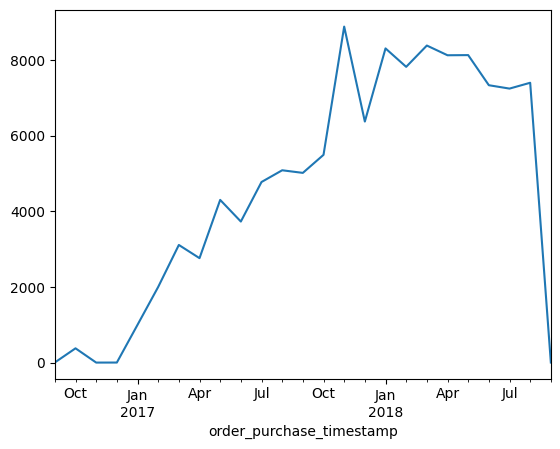

In [42]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df.set_index('order_purchase_timestamp').resample('ME').size().plot()

In [43]:
def converting_to_datetime (df):
    """
    Converting the dates in the dataset into pandas datetime data type
    """
    df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
    df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
    df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
    df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])
    df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'])
    df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

    return df

In [44]:
def Extracting_Date_Features (df):
    """
    Extracting features from existing features and converting them to float
    (for example, a 1 days 12:00:00 it will be converted to 1.5)
    1) order approval time >>> the amount of time it took the company approve the order
    2) approval carrier time >>> time taken from the order approval to carrier delivery
    3) delivery from carrier >>> time taken from the carrier to the customer delivery
    4) order to carrier delivery >>> time from order placement to carrier delivery
    5) order to customer delivery >>> time from order placement to customer delivery
    6) order to estimated delivery >>> time from order placement to the estimated time given to the customer
    """
    
    df['order_approval_time'] =  (df['order_approved_at'] - df['order_purchase_timestamp']) / pd.Timedelta(days=1)
    df['approval_carrier_time'] = (df['order_delivered_carrier_date'] - df['order_approved_at']) / pd.Timedelta(days=1)
    df['delivery_from_carrier'] = (df['order_delivered_customer_date'] - df['order_delivered_carrier_date']) / pd.Timedelta(days=1)
    
    df['order_to_carrier_delivery'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']) / pd.Timedelta(days=1)
    df['order_to_cutomer_delivery'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']) / pd.Timedelta(days=1)
    df['order_to_estimated_delivery'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']) / pd.Timedelta(days=1)
    return df

In [45]:
def extracting_features_value (df):
    '''
    1- the target is late_delivery
    1) 1 : the delivery is late
    2) 0 : the delivery is on time

    2- extracting late delivery in days
    3- customer and seller from the same state
    '''
    df['late_delivery'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype('int64')
    df['late_delivery_days'] =  (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']) / pd.Timedelta(days=1)
    df['same_state'] = df['customer_state'] == df['seller_state']
    return df

In [46]:
def drop_cols(df):
    unuseful_columns = ['order_id', 'customer_id', 'customer_unique_id', 'order_item_id','product_id','seller_id',
    'review_id',
    'review_score',
    'review_comment_title',
    'review_comment_message',
    'review_creation_date',
    'review_answer_timestamp',
    'product_category_name',
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'customer_zip_code_prefix',
    'customer_city',
    'seller_zip_code_prefix']
    
    date_columns = ['order_purchase_timestamp','order_approved_at',
                    'order_delivered_carrier_date','order_delivered_customer_date',
                   'order_estimated_delivery_date','shipping_limit_date'] # after applying feature extractions
    unuseful_columns.extend(date_columns)
    df.drop(columns = unuseful_columns, inplace= True)
    return df

In [47]:
df = converting_to_datetime(df)
df = Extracting_Date_Features(df)
df = extracting_features_value(df)
df = drop_cols(df)

In [48]:
df.head()

,order_status,customer_state,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name_english,seller_city,seller_state,order_approval_time,approval_carrier_time,delivery_from_carrier,order_to_carrier_delivery,order_to_cutomer_delivery,order_to_estimated_delivery,late_delivery,late_delivery_days,same_state
0,delivered,SP,29.99,8.72,1,credit_card,1,18.12,housewares,maua,SP,0.007431,2.366493,6.062650,2.373924,8.436574,15.544063,0,7.107488,True
1,delivered,SP,29.99,8.72,3,voucher,1,2.00,housewares,maua,SP,0.007431,2.366493,6.062650,2.373924,8.436574,15.544063,0,7.107488,True
2,delivered,SP,29.99,8.72,2,voucher,1,18.59,housewares,maua,SP,0.007431,2.366493,6.062650,2.373924,8.436574,15.544063,0,7.107488,True
3,delivered,BA,118.70,22.76,1,boleto,1,141.46,perfumery,belo horizonte,SP,1.279745,0.462882,12.039410,1.742627,13.782037,19.137766,0,5.355729,False
4,delivered,GO,159.90,19.22,1,credit_card,3,179.12,auto,guariba,SP,0.011505,0.204595,9.178113,0.216100,9.394213,26.639711,0,17.245498,False


## Exploratory Data Analysis

In [49]:
df.shape

(115609, 20)

In [50]:
df.columns

Index(['order_status', 'customer_state', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'product_category_name_english', 'seller_city',
       'seller_state', 'order_approval_time', 'approval_carrier_time',
       'delivery_from_carrier', 'order_to_carrier_delivery',
       'order_to_cutomer_delivery', 'order_to_estimated_delivery',
       'late_delivery', 'late_delivery_days', 'same_state'],
      dtype='object')

In [51]:
df.dtypes

order_status                      object
customer_state                    object
price                            float64
freight_value                    float64
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
product_category_name_english     object
seller_city                       object
seller_state                      object
order_approval_time              float64
approval_carrier_time            float64
delivery_from_carrier            float64
order_to_carrier_delivery        float64
order_to_cutomer_delivery        float64
order_to_estimated_delivery      float64
late_delivery                      int64
late_delivery_days               float64
same_state                          bool
dtype: object

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115609 entries, 0 to 115608
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_status                   115609 non-null  object 
 1   customer_state                 115609 non-null  object 
 2   price                          115609 non-null  float64
 3   freight_value                  115609 non-null  float64
 4   payment_sequential             115609 non-null  int64  
 5   payment_type                   115609 non-null  object 
 6   payment_installments           115609 non-null  int64  
 7   payment_value                  115609 non-null  float64
 8   product_category_name_english  115609 non-null  object 
 9   seller_city                    115609 non-null  object 
 10  seller_state                   115609 non-null  object 
 11  order_approval_time            115595 non-null  float64
 12  approval_carrier_time          1144

In [53]:
df.describe()

,price,freight_value,payment_sequential,payment_installments,payment_value,order_approval_time,approval_carrier_time,delivery_from_carrier,order_to_carrier_delivery,order_to_cutomer_delivery,order_to_estimated_delivery,late_delivery,late_delivery_days
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115595.000000,114400.000000,113208.000000,114414.000000,113209.000000,115609.000000,115609.000000,113209.000000
mean,120.619850,20.056880,1.093747,2.946233,172.387379,0.437634,2.843217,9.168334,3.279226,12.442148,23.866239,0.075383,11.395439
std,182.653476,15.836184,0.729849,2.781087,265.873969,0.927670,3.545346,8.553770,3.618769,9.356008,8.888722,0.264010,10.093341
min,0.850000,0.000000,1.000000,0.000000,0.000000,0.000000,-171.219005,-16.096169,-171.212419,0.533414,2.008009,0.000000,-188.975081
25%,39.900000,13.080000,1.000000,1.000000,60.870000,0.008993,0.884664,4.062905,1.137159,6.739016,18.408333,0.000000,6.549340
50%,74.900000,16.320000,1.000000,2.000000,108.050000,0.014479,1.842940,7.059144,2.229635,10.188437,23.262627,0.000000,12.068461
75%,134.900000,21.210000,1.000000,4.000000,189.480000,0.624201,3.637031,11.909980,4.115793,15.503484,28.482014,0.000000,16.324063
max,6735.000000,409.680000,29.000000,24.000000,13664.080000,60.452766,107.053218,205.190972,107.064606,208.351759,155.135463,1.000000,146.016123


### Handling the null and duplicated values

In [54]:
df.isnull().sum()

order_status                        0
customer_state                      0
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
product_category_name_english       0
seller_city                         0
seller_state                        0
order_approval_time                14
approval_carrier_time            1209
delivery_from_carrier            2401
order_to_carrier_delivery        1195
order_to_cutomer_delivery        2400
order_to_estimated_delivery         0
late_delivery                       0
late_delivery_days               2400
same_state                          0
dtype: int64

In [55]:
df.dropna(inplace = True)

In [56]:
df.duplicated().sum()

11555

In [57]:
df.drop_duplicates(inplace= True)

In [58]:
df['late_delivery'].value_counts()

late_delivery
0    93704
1     7935
Name: count, dtype: int64

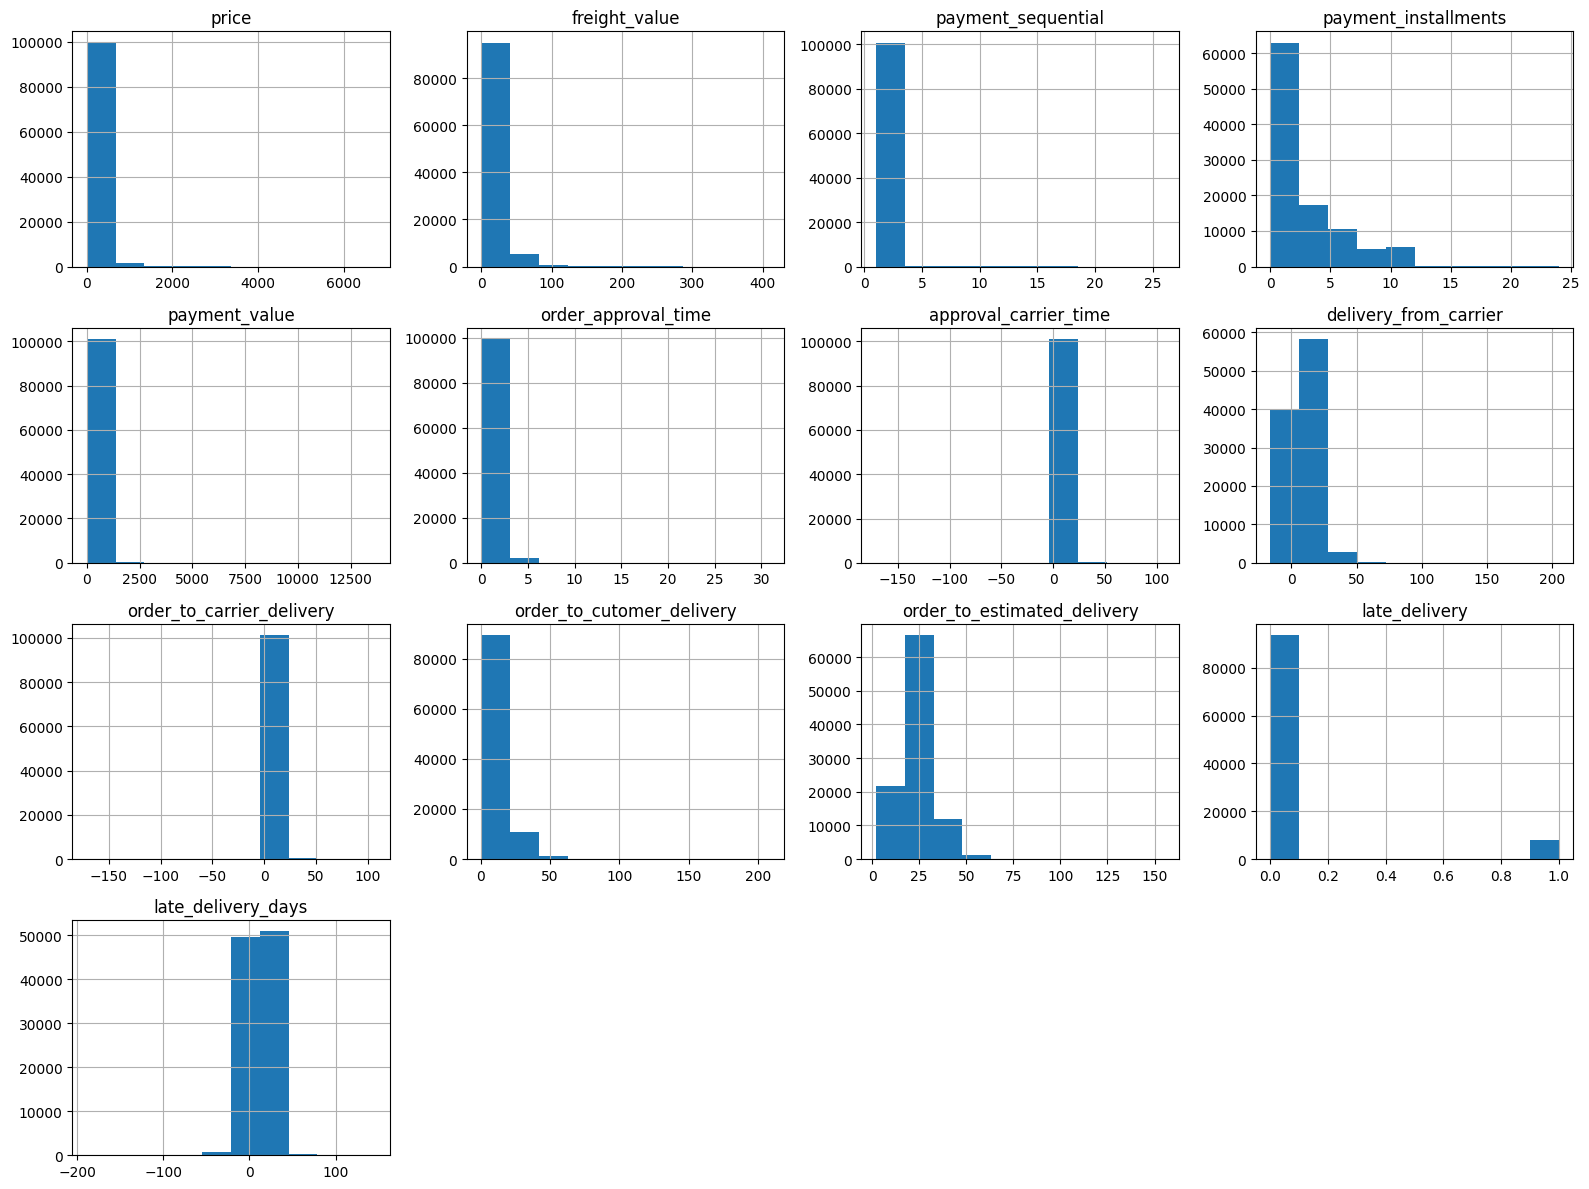

In [59]:
df.hist(figsize=(16,12), bins = 10)
plt.xticks(rotation=45)
plt.title("Numerical attributes Histogram")
plt.tight_layout()

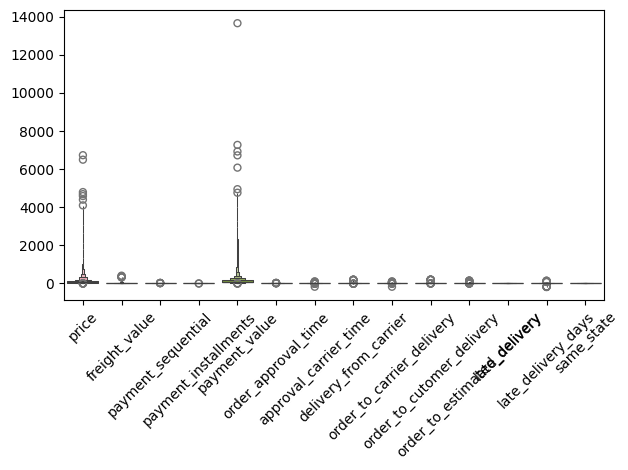

In [60]:
sns.boxenplot(df)
plt.xticks(rotation= 45)
plt.tight_layout()

In [61]:
# we have only one outlier which is in the payment_value
df['payment_value'].sort_values(ascending= False)

15472     13664.08
77337      7274.88
25783      6929.31
4049       6726.66
37701      6081.54
            ...   
110763        0.01
99640         0.00
37659         0.00
112728        0.00
491           0.00
Name: payment_value, Length: 101639, dtype: float64

In [62]:
df.loc[13697, 'payment_value'] = 7274.88

In [63]:
df.iloc[13697]

order_status                           delivered
customer_state                                RJ
price                                     1680.0
freight_value                              28.01
payment_sequential                             1
payment_type                         credit_card
payment_installments                           1
payment_value                           13664.08
product_category_name_english    fixed_telephony
seller_city                            sao paulo
seller_state                                  SP
order_approval_time                     3.002407
approval_carrier_time                   8.010382
delivery_from_carrier                   7.110556
order_to_carrier_delivery              11.012789
order_to_cutomer_delivery              18.123345
order_to_estimated_delivery            23.357731
late_delivery                                  0
late_delivery_days                      5.234387
same_state                                 False
Name: 15472, dtype: 

In [64]:
df['order_status'].value_counts()

order_status
delivered    101632
canceled          7
Name: count, dtype: int64

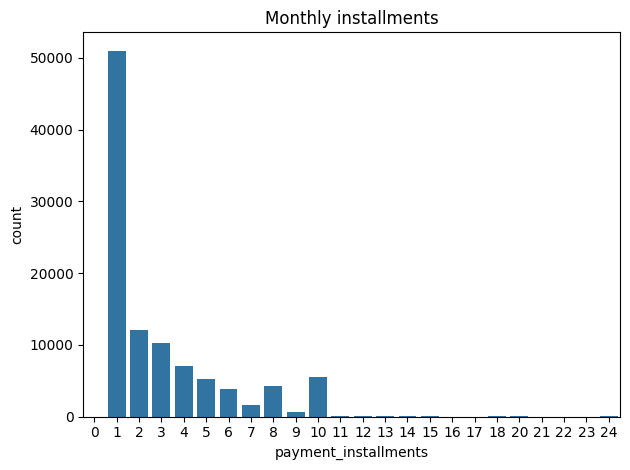

In [65]:
sns.barplot(df['payment_installments'].value_counts())
plt.title("Monthly installments")
plt.tight_layout()

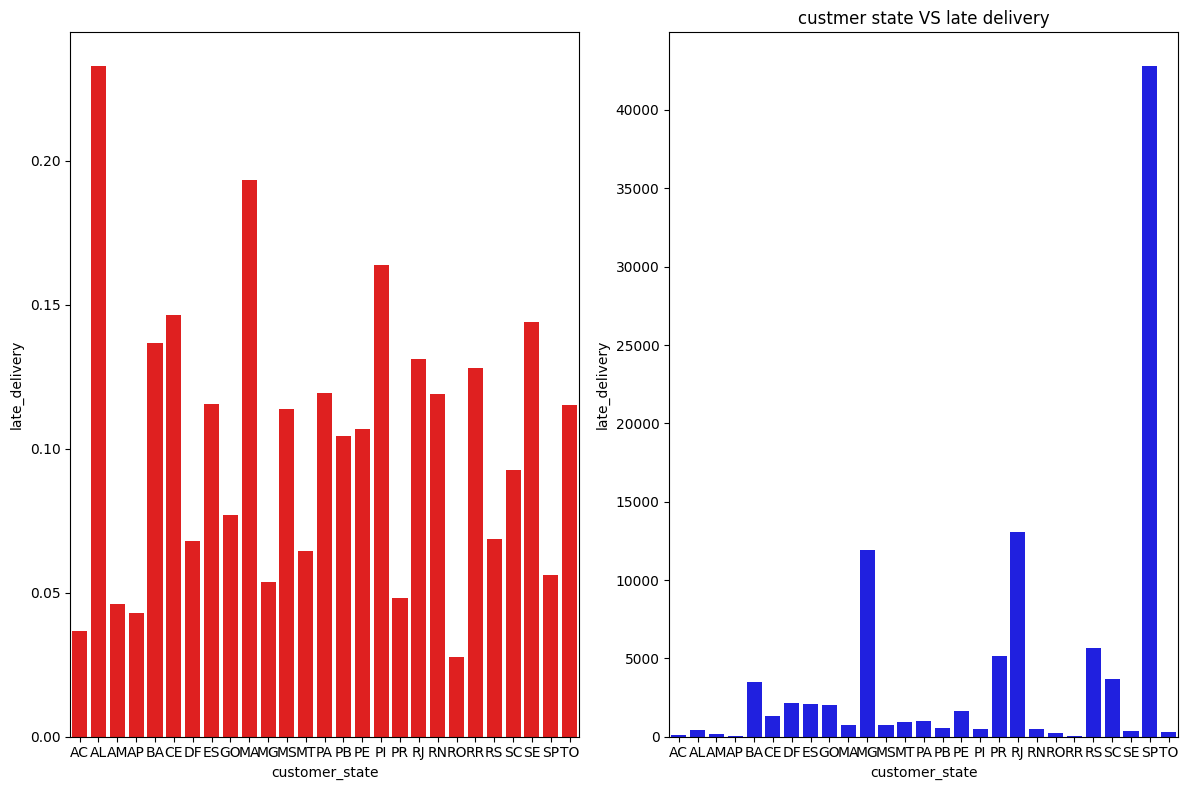

In [66]:
# Tried the count before but its better to use the mean since it gives an intuation
# about the number of purchases made in this state
fig, axes = plt.subplots(1,2, figsize=(12,8))
customer_state_delivery =  df.groupby('customer_state')['late_delivery'].mean()
sns.barplot(customer_state_delivery, color="r", ax=axes[0])
plt.title("custmer state VS late delivery")

customer_state_delivery_count =  df.groupby('customer_state')['late_delivery'].count()
sns.barplot(customer_state_delivery_count, color="b", ax=axes[1])
plt.tight_layout()

In [67]:
df['late_delivery'].value_counts()

late_delivery
0    93704
1     7935
Name: count, dtype: int64

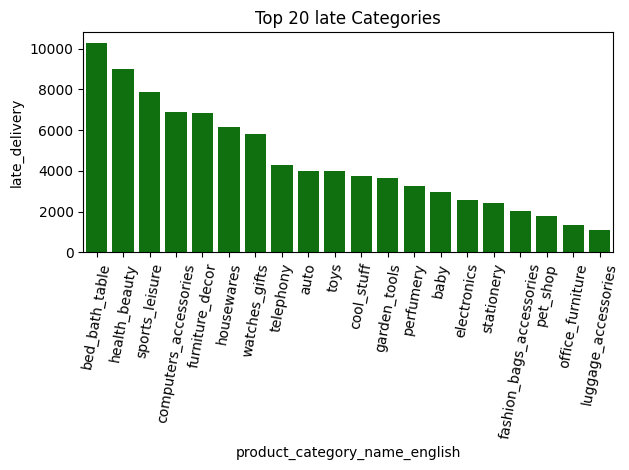

In [68]:
cat_late_delivery = df.groupby('product_category_name_english').count()
hightest_20_late_cat = cat_late_delivery['late_delivery'].sort_values(ascending= False)[:20]
sns.barplot(hightest_20_late_cat, color= 'green')

plt.title("Top 20 late Categories")
plt.xticks(rotation = 80)
plt.tight_layout()

C:\Users\alaa_\AppData\Local\Temp\ipykernel_21212\3948680659.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['late_delivery_days'])


<Axes: xlabel='late_delivery_days', ylabel='Density'>

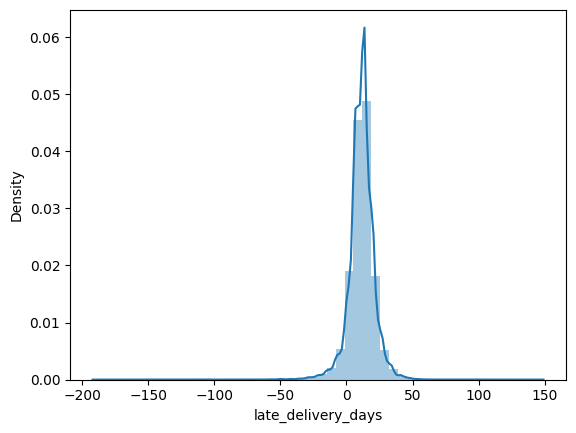

In [69]:
sns.distplot(df['late_delivery_days'])

<Axes: xlabel='same_state', ylabel='late_delivery'>

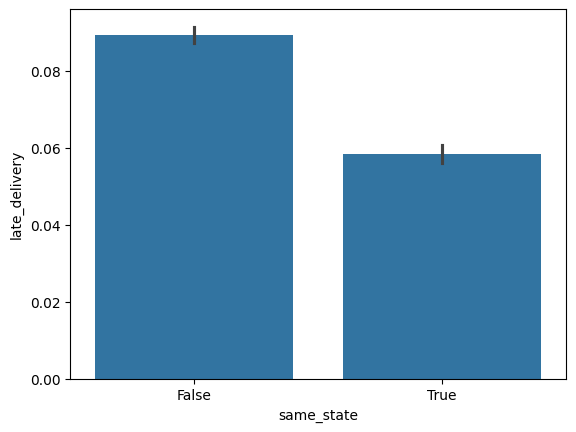

In [70]:
'''there is a decent percentage of orders even with being from the same state 
still got a late delviery
'''
sns.barplot(x='same_state', y ='late_delivery', data = df)

<Axes: >

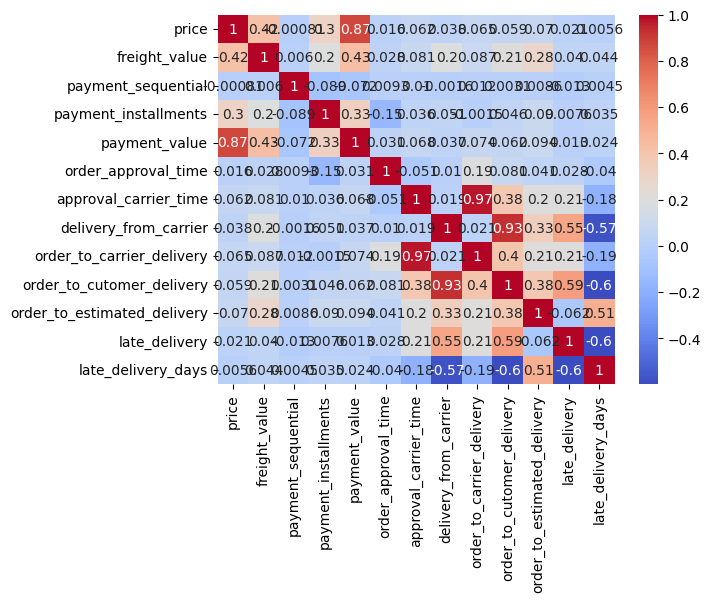

In [71]:
num_cols = list(df.select_dtypes(['float64', 'int64']).columns)
cat_cols = list(df.select_dtypes(object).columns)

corr = df[num_cols].corr()
sns.heatmap(corr, annot= True, cmap= 'coolwarm')

In [72]:
y = df['late_delivery']
num_cols.remove('late_delivery')

In [75]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(sparse_output= False, drop='if_binary'), cat_cols)
    ]
)

In [76]:
processed = preprocessor.fit_transform(df)
cat_cols_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_col_names = num_cols + list(cat_cols_names)

preprocessed_df = pd.DataFrame(processed, columns= all_col_names)
preprocessed_df

,price,freight_value,payment_sequential,payment_installments,payment_value,order_approval_time,approval_carrier_time,delivery_from_carrier,order_to_carrier_delivery,order_to_cutomer_delivery,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,-0.502938,-0.722299,-0.134460,-0.694830,-0.637520,-0.489048,-0.119459,-0.369822,-0.234873,-0.428115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.502938,-0.722299,2.845571,-0.694830,-0.711926,-0.489048,-0.119459,-0.369822,-0.234873,-0.428115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.502938,-0.722299,1.355555,-0.694830,-0.635350,-0.489048,-0.119459,-0.369822,-0.234873,-0.428115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.029050,0.164213,-0.134460,-0.694830,-0.068210,1.001488,-0.664307,0.321098,-0.412485,0.139190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.191040,-0.059309,-0.134460,0.040607,0.105620,-0.484275,-0.738234,-0.009671,-0.841967,-0.326482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101634,-0.278521,-0.447000,-0.134460,0.040607,-0.328447,-0.497753,-0.493885,-0.243002,-0.605015,-0.451311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
101635,0.271170,-0.003744,-0.134460,0.040607,0.178919,-0.488275,-0.388915,1.329276,-0.499556,1.031907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
101636,0.437253,2.832588,-0.134460,0.776045,0.529764,-0.483475,-0.441372,1.658147,-0.549967,1.314813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
101637,0.298361,1.290032,-0.134460,0.408326,1.315138,-0.491326,0.276267,0.470505,0.153570,0.489878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
X_train, X_full, y_train, y_full = train_test_split(preprocessed_df, y, random_state=42,
                                                   test_size=.3)
X_test, X_val, y_test, y_val = train_test_split(X_full, y_full, random_state=40,
                                               test_size= .5)

In [84]:
lin_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate= .01, random_state=42)

lin_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [90]:
for name, model in [('LogReg', lin_model),('RandomForest', rf_model),
                    ('XGBoost', xgb)] :
    print(f"the model name    {name}")
    preds = model.predict(X_test)
    print()
    print(classification_report(y_test, preds))
    print(mean_absolute_error(y_test, preds))
    print(f1_score(y_test, preds))

    print()
    print("-" * 30)

the model name    LogReg

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14046
           1       1.00      0.99      0.99      1200

    accuracy                           1.00     15246
   macro avg       1.00      0.99      1.00     15246
weighted avg       1.00      1.00      1.00     15246

0.0010494555949101404
0.9933054393305439

------------------------------
the model name    RandomForest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14046
           1       1.00      1.00      1.00      1200

    accuracy                           1.00     15246
   macro avg       1.00      1.00      1.00     15246
weighted avg       1.00      1.00      1.00     15246

0.0
1.0

------------------------------
the model name    XGBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14046
           1       1.00      1.00      

In [92]:
for name, model in [('LogReg', lin_model),('RandomForest', rf_model),
                    ('XGBoost', xgb)] :
    print(f"the model name    {name}")
    preds = model.predict(X_val)
    print()
    print(classification_report(y_val, preds))
    print(mean_absolute_error(y_val, preds))
    print(f1_score(y_val, preds))

    print()
    print("-" * 30)

the model name    LogReg

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14089
           1       1.00      0.99      0.99      1157

    accuracy                           1.00     15246
   macro avg       1.00      0.99      1.00     15246
weighted avg       1.00      1.00      1.00     15246

0.0009838646202282567
0.9934867564046895

------------------------------
the model name    RandomForest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14089
           1       1.00      1.00      1.00      1157

    accuracy                           1.00     15246
   macro avg       1.00      1.00      1.00     15246
weighted avg       1.00      1.00      1.00     15246

0.0
1.0

------------------------------
the model name    XGBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14089
           1       1.00      1.00      

#### The best model, which is not overfitting since it performs well with the unseen data, is the Random Forest model

* Now we need to train the model on the full dataset and save it as our best model, knowing that the model doesn't need fine-tuning since it performs well with the default parameters

In [95]:
best_model = rf_model.fit(preprocessed_df,y)

In [99]:
with open ( "Random_Forest_model.pkl", 'wb') as file:
    pickle.dump(best_model, file)